In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import util
from test_to_bw_fast import read_model
import metrics
import wandb, os
from test_to_bw_fast import get_config
from tfr_evaluate import get_true_pred, change_resolution
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from test_to_bw_fast import open_bw
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from tqdm import tqdm
from scipy.spatial import distance
from scipy import stats
import pickle
from test_to_bw_fast import get_config, enforce_constant_size
from metrics import get_pearsonr_per_seq, get_mse, get_js_per_seq, get_poiss_nll
import umap.umap_ as umap
import subprocess
import loss

In [33]:
trainset_results = pd.read_csv('summary_metrics_tables/BASENJI_TRAINSET_THRESHOLD.csv')

In [83]:
dataset_label = {'peak_centered': 'peak centered',
                'random_chop': 'threshold=2',
                 'threshold_4':'threshold=4',
                 'threshold_6':'threshold=6',
                 'threshold_8':'threshold=8',
                'threshold_10':'threshold=10'}
trainset_results['dataset'] = [dataset_label[d.split('/i_3072')[0].split('/')[-1]] for d in trainset_results['data_dir'].values]

In [84]:
both_testsets = []
for testset_type in ['whole', 'idr']:
    whole_raw_results = trainset_results[(trainset_results['pred type']=='raw')&
                                        (trainset_results['eval type']==testset_type)]

    metrics = whole_raw_results.groupby(['bin_size', 'dataset']).mean().reset_index()
    descriptions = whole_raw_results.iloc[:,8:]
    avg_metrics_per_run = metrics.merge(descriptions,how='left', on=['bin_size', 'dataset']).drop_duplicates(subset=['bin_size','dataset','eval type'])
    avg_metrics_per_run['testset type'] = testset_type
    both_testsets.append(avg_metrics_per_run)
both_testsets = pd.concat(both_testsets)

In [85]:
both_testsets

,bin_size,dataset,index,mse,js_per_seq,js_conc,poiss,pr,l_rate_x,num_epochs_x,window_size_x,eval type,data_dir,l_rate_y,loss_fn,model_fn,num_epochs_y,window_size_y,testset type
0,1,peak centered,7,0.823123,0.337659,0.377549,0.832575,0.552698,0.001,100,2048,whole,datasets/complete/peak_centered/i_3072_w_1,0.001,poisson,basenji_w1_b64,100,2048,whole
15,1,threshold=10,7,0.759411,0.335276,0.372136,0.819472,0.565901,0.001,100,2048,whole,datasets/train_thresholds/threshold_10/i_3072_w_1,0.001,poisson,basenji_w1_b64,100,2048,whole
30,1,threshold=2,7,0.687882,0.331949,0.366811,0.807386,0.577337,0.001,100,2048,whole,datasets/complete/random_chop/i_3072_w_1,0.001,poisson,basenji_w1_b64,100,2048,whole
45,1,threshold=4,7,0.683453,0.332001,0.368528,0.807673,0.580493,0.001,100,2048,whole,datasets/train_thresholds/threshold_4/i_3072_w_1,0.001,poisson,basenji_w1_b64,100,2048,whole
60,1,threshold=6,7,0.701550,0.333241,0.370946,0.811114,0.572064,0.001,100,2048,whole,datasets/train_thresholds/threshold_6/i_3072_w_1,0.001,poisson,basenji_w1_b64,100,2048,whole
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2048,threshold=10,0,0.724585,0.167020,0.216743,0.256796,0.769306,0.001,100,2048,idr,datasets/train_thresholds/threshold_10/i_3072_w_1,0.001,poisson,basenjimod,100,2048,idr
660,2048,threshold=2,0,0.836985,0.162491,0.219834,0.283612,0.773587,0.001,100,2048,idr,datasets/complete/random_chop/i_3072_w_1,0.001,poisson,basenjimod,100,2048,idr
675,2048,threshold=4,0,0.793726,0.166925,0.217730,0.271761,0.779467,0.001,100,2048,idr,datasets/train_thresholds/threshold_4/i_3072_w_1,0.001,poisson,basenjimod,100,2048,idr
690,2048,threshold=6,0,0.757869,0.168459,0.216868,0.263637,0.773161,0.001,100,2048,idr,datasets/train_thresholds/threshold_6/i_3072_w_1,0.001,poisson,basenjimod,100,2048,idr


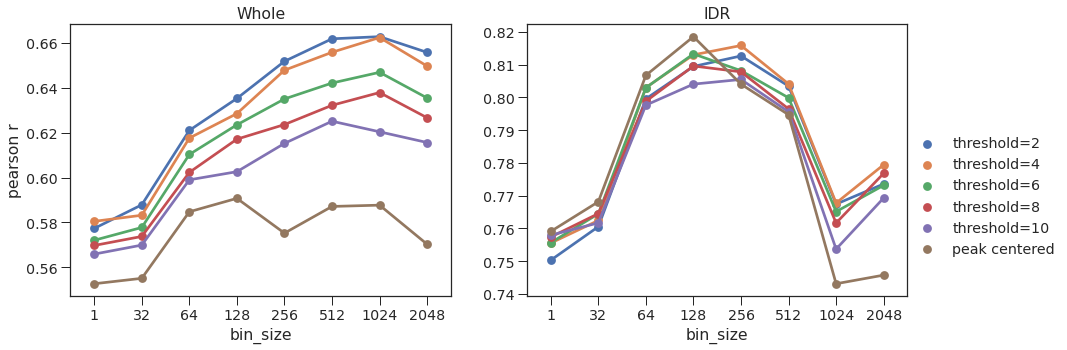

In [93]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
fig, axs = plt.subplots(1,2, figsize=[15,5])
testset_types = ['whole', 'idr']
titles = ['Whole', 'IDR']
metric = {'pearson r':'pr'}
for t, testset_type in enumerate(testset_types):
    ax=axs[t]
    sns.pointplot(data=both_testsets[both_testsets['eval type']==testset_type], 
                  x='bin_size', y=list(metric.values())[0], hue='dataset', ax=ax, 
                  hue_order=['threshold=2', 'threshold=4', 'threshold=6', 'threshold=8', 
                             'threshold=10','peak centered'] )
#     ax.set_xticks(rotation=45);
    ax.set_title(titles[t])
plt.legend(loc='lower center',bbox_to_anchor=(1.2,0.1),frameon=False)
axs[0].get_legend().remove()
axs[0].set_ylabel(list(metric.keys())[0]);
axs[1].set_ylabel('');

In [113]:
idr_df = both_testsets[(both_testsets['eval type']=='idr')&
                      (both_testsets['bin_size']==512)]

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

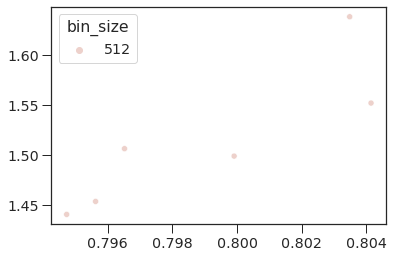

In [114]:
sns.scatterplot(idr_df['pr'].values, idr_df['mse'].values, hue=idr_df['bin_size'],legend="full")